In [156]:
import os
import openai

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import uuid
import json
import regex

from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)  # for exponential backoff

import sys
sys.path.insert(0,'..')
from utils import get_file_encodings

from FileHandler import FileHandler

openai.organization = ""
openai.api_key = ""

In [157]:
@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def completion_with_backoff(**kwargs):
    return openai.ChatCompletion.create(**kwargs)

def call_chatgpt(file_contents):
    response = completion_with_backoff(
    model="gpt-3.5-turbo",
    messages=[
            {"role": "system", "content": "Consider this SQL file: " + file_contents},
            {"role": "user", "content": "Return one JSON object with the following keys: '1' and '2'. First, for json key '1', in JSON format, find and return the following from the SQL file: 1) a list of distinct table names using JSON key 'tables' ; 2) a list of distinct column names using JSON key 'columns' (do not link the columns to the tables) ; 3) a list of distinct database names using JSON key 'dbs' ; 3) a  list of distinct schema names using JSON key 'schemas'; 4) a list of distinct view names using JSON key 'views'. Do not return any other text in the response other than the JSON object. Then, separately, for json key '2', in JSON format: find and return the following from the SQL file: 1) number of columns that have a NOT NULL constraint using JSON key 'num_ctr_notnull' ; 2) number of columns that have a primary key constraint using JSON key 'num_ctr_pk' ; 3) number of columns that have a unique constraint using JSON key 'num_ctr_uk' ; 4) number of columns that are foreign keys using JSON key 'num_ctr_fk'. Do not return any other text in the response other than the JSON object."}
        ]
    )

    return response

def count_tokens_from_response(response):
    try:
       out = response['usage']['total_tokens']
    except KeyError:
       out = 0
    return out 
    
def parse_response(response):
    try:
        results = json.loads(response['choices'][0]['message']['content'])
    except json.JSONDecodeError:
        try:
            pattern = regex.compile(r'\{(?:[^{}]|(?R))*\}')
            results = json.loads(pattern.findall(response['choices'][0]['message']['content'])[0])
        except:
            results = None
    except KeyError:
        results = None
    except TypeError:
        results = None

    table_list = []
    col_list = []
    db_list = []
    sch_list = []
    vw_list = []

    nn = 0
    fk = 0
    pk = 0
    uk = 0

    if results is not None:
        try:
            interm = results['1']
            table_list = list(set([item.upper() for item in (interm['tables'] or []) if item is not None]))
            col_list = list(set([item.upper() for item in (interm['columns'] or []) if item is not None]))
            db_list = list(set([item.upper() for item in (interm['dbs'] or []) if item is not None]))
            sch_list = list(set([item.upper() for item in (interm['schemas'] or []) if item is not None]))
            vw_list = list(set([item.upper() for item in (interm['views'] or []) if item is not None]))
        except KeyError:
            pass

        try:
            interm = results['2']
            nn = interm['num_ctr_notnull']
            pk = interm['num_ctr_pk']
            uk = interm['num_ctr_uk']
            fk = interm['num_ctr_fk']
        except KeyError:
            pass

    return table_list,col_list,db_list,sch_list,vw_list, nn,fk,pk,uk

<Axes: >

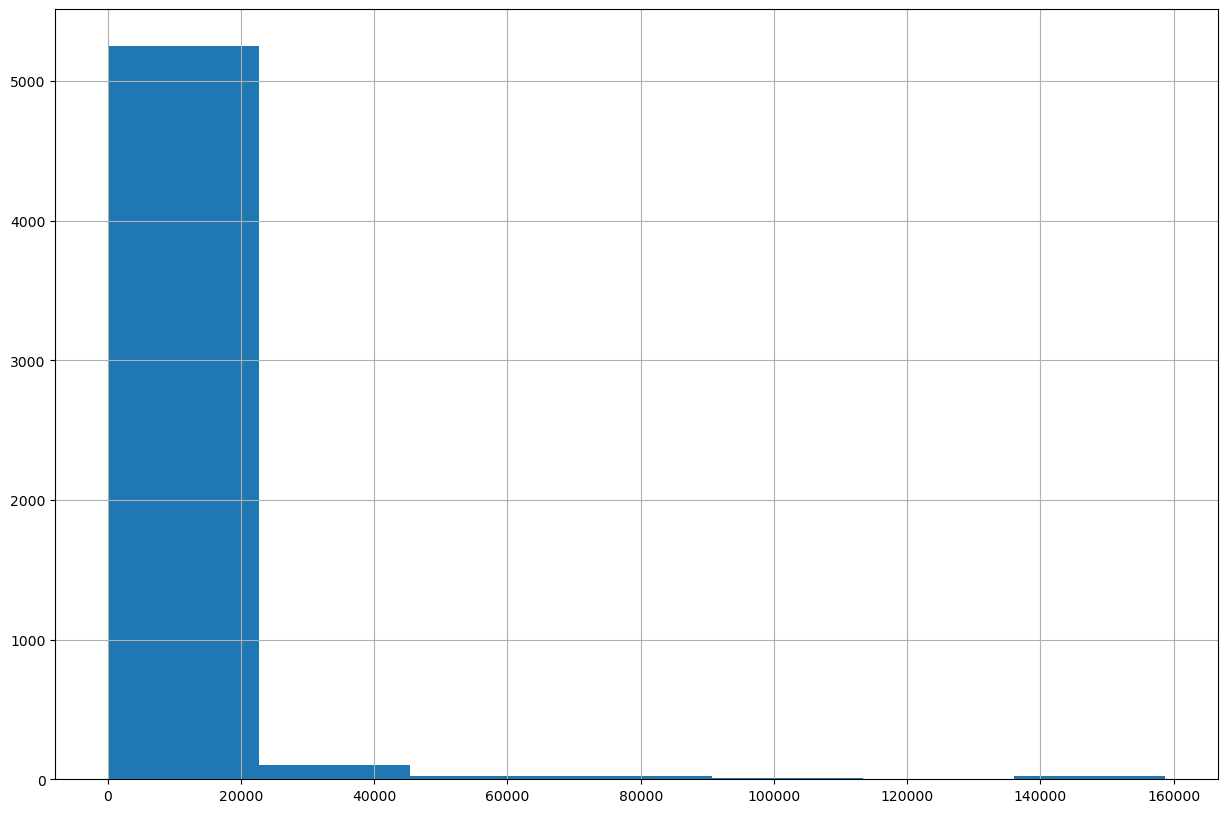

In [158]:
token_count = pd.read_csv('token_count.csv',dtype={'a':str,'file_id': str,'file_path':str,'n_tokens':np.int64})

# 5432
candidates = pd.read_csv('files_parsable_only_by_pglast.csv',dtype={'file_id':str})
candidates = candidates.merge(token_count,on=['file_id'],how='inner')
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
candidates['n_tokens'].hist(bins=7)

In [159]:
candidates[candidates.n_tokens<4000]['n_tokens'].sum()

# 19 081 177 sum of tokens (ALL)
# 3 554 853 sum of tokens (n_tokens < 4000)

3554853

In [160]:
encodings = get_file_encodings('../../data/filedetails/')


to_remove = pd.read_csv('already_parsed.csv',dtype={'file_id':str})
to_remove = to_remove.merge(token_count,on=['file_id'],how='inner')
already_done_tokens = to_remove['n_tokens'].sum()

candidates = candidates.merge(to_remove, on=['file_id'], 
                   how='left', indicator=True)

candidates = candidates[candidates['_merge'] == 'left_only']

# 4096 max, 280 other prompt => 
candidates = candidates[candidates.n_tokens_x < 2800]

random_samples = candidates.sample(n=candidates.shape[0], random_state=1)
to_parse = random_samples[random_samples.n_tokens_x.cumsum() < 4000000 - already_done_tokens*1.5]

to_parse.reset_index(drop=True,inplace=True)
to_parse.count()

file_id         2374
Unnamed: 0_x    2374
file_path_x     2374
n_tokens_x      2374
Unnamed: 0_y       0
file_path_y        0
n_tokens_y         0
_merge          2374
dtype: int64

In [ ]:
done = []

token_counter = 0
file_counter = 0

for index, row in to_parse.iterrows():

    f = FileHandler(row['file_path_x'])
    f.file_open(file_encoding=encodings[row['file_id']])
    f.file_read()
    f.file_close()
    
    result = {'file_id': row['file_id'],
              'error': 0}

    response = call_chatgpt(f.file_contents)
    result['finish_reason'] = response['choices'][0]['finish_reason']
    result['orig_response'] = str(response)
    result['used_tokens'] = count_tokens_from_response(response)
    token_counter += result['used_tokens']

    if result['finish_reason'] == 'length':
        table_list,col_list,db_list,sch_list,vw_list, nn,fk,pk,uk = parse_response(None)
        result['error'] = 2
    else:
        try:
            table_list,col_list,db_list,sch_list,vw_list, nn,fk,pk,uk = parse_response(response)
        except Exception as e:
            if "sorry" in response['choices'][0]['message']['content'].lower():
                table_list,col_list,db_list,sch_list,vw_list, nn,fk,pk,uk = parse_response(None)
                result['error'] = 1
            else:
                table_list,col_list,db_list,sch_list,vw_list, nn,fk,pk,uk = parse_response(None)
                result['error'] = 1
                print(response)
                print("===")
                print(e)
                break
    
    result['table_list'] = table_list
    result['column_list'] = col_list
    result['schema_list'] = sch_list
    result['db_list'] = db_list
    result['view_list'] = vw_list

    result['num_ctr_notnull'] = nn
    result['num_ctr_unique'] = uk
    result['num_ctr_primary'] = pk
    result['num_ctr_foreign'] = fk
    
    out_file_path = '../../data/chatgpt/' + str(uuid.uuid4()) + '.json'

    with open(out_file_path, 'w+', encoding='utf-8') as outf:
        json.dump(result, outf, ensure_ascii=False, indent=4)

    done.append({'file_id': row['file_id']})
    file_counter += 1

    # 500k tokens = 1 $
    if file_counter % 10 == 0:
        print(str(file_counter) + '|' + str(token_counter))

    if index > 500:
        break

    already_parsed = pd.DataFrame([{'file_id': row['file_id']}])
    already_parsed.to_csv('already_parsed.csv', mode='a', header=False,index=False)